In [1]:
import numpy as np
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
import math

from opossum import UserInterface
import matplotlib.pyplot as plt
import causalml
from causalml.inference.meta import LRSRegressor
from xgboost import XGBRegressor
from causalml.inference.meta import BaseRRegressor
from causalml.propensity import ElasticNetPropensityModel

from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [2]:
## create datasets in an array?
## for each thing in the data set, take each array and split into 1/3. two new arrays : Test and StackingTrain. 
# dataSetArray...
N = 3000
k = 10
seed= 5

u = UserInterface(N, k, seed=seed, categorical_covariates = None)

X=[]
assignment=[]
y=[]
treatment=[]
propensityScores=[]

def splitArrays(l):
    return np.array_split(l, 3)

def addDatasets(y_gen, X_gen, assignment_gen, treatment_gen):
    X.append(splitArrays(X_gen))
    y.append(splitArrays(y_gen))
    assignment.append(splitArrays(assignment_gen))
    treatment.append(splitArrays(treatment_gen))
    
    
####IMPORTANT: after generating the data, we wish to split the dataset into three parts:
## one for training the R learner => 0
## one for fitting the OLS stacking model => 1
## and one for testing. => 2

### because of the nature of the opossum data set output, we will use numpy arrays
### after generating a dataset, we add the dataset to an array of datasets. each entry in this (super)array of datasets
### contains three sub arrays. one train, one stacking, one test array. 

## so accessing the training dataset of the second data generating funciton is then: X[1][0]
## accessing the treatment vector (true treatment effect) of the first data set, testing data: treatment[0][2]

In [3]:
##############################################################################################
## setupA => difficult nuisance com-ponents and an easy treatment effect function
##############################################################################################
u.generate_treatment(random_assignment = False, 
                     assignment_prob = 'low', 
                     constant_pos = False, 
                     constant_neg = False,
                     heterogeneous_pos = True, 
                     heterogeneous_neg = False, 
                     no_treatment = False, 
                     discrete_heterogeneous = False,
                     treatment_option_weights = None, 
                     intensity = 10)

y_A, X_A, assignment_A, treatment_A = u.output_data(binary=False, 
                                               x_y_relation = 'nonlinear_interaction')

addDatasets(y_A, X_A, assignment_A, treatment_A)

In [4]:
##############################################################################################
## setupB => randomized trial
##############################################################################################
u.generate_treatment(random_assignment = True, 
                     assignment_prob = 0.5, 
                     treatment_option_weights = [0.0, 0.0, 0.4, 0.6, 0.0, 0.0],
                     intensity = 5)

y_B, X_B, assignment_B, treatment_B = u.output_data(binary=False, x_y_relation = 'linear_simple')

addDatasets(y_B, X_B, assignment_B, treatment_B)

In [5]:
##############################################################################################
## setupC => easy propensity score and difficult baseline
##############################################################################################
u.generate_treatment(random_assignment = False, 
                     assignment_prob = 'low', 
                     constant_pos = True, 
                     constant_neg = False,
                     heterogeneous_pos = False, 
                     heterogeneous_neg = False, 
                     no_treatment = False, 
                     discrete_heterogeneous = False,
                     treatment_option_weights = None, 
                     intensity = 10)

y_C, X_C, assignment_C, treatment_C = u.output_data(binary=False, 
                                               x_y_relation = 'nonlinear_interaction')

addDatasets(y_C, X_C, assignment_C, treatment_C)


##############################################################################################
## setupD => unrelated treatment and control arms???
##############################################################################################


In [6]:
## Get propensity scores using CausalML package. (scores for each dataset and save them in an array)
propensityScores_train = []

for x in range(3):
    pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
    estimatedpropensityscores = pm.fit_predict(X[x][0], assignment[x][0])
    propensityScores_train.append(estimatedpropensityscores)
    
    
#### INFO : the R learner (and others) need propensity scores. there are many ways to compute propensity scores. 
#### we can do them on the fly when we call the BaseRRegressor, and estimmate_ate .. default is actuallz elasticnetpropensitymodel
#### but we can also compute them ourselves. 

### compute 1 propensity score per dataset for the R learner. we dont need the propensity score for the ols or for the testing. 

### BUT NOTICE THAT beacuse we dont feed propensitz score into the stacking step, we can see how mis-estimation 
### of the propensity score can skew the stacking step. Nie and Wager talk about how bias is absorbed into the intercept term. 

In [7]:
##############################################################################################
## R learner, three kinds of base regressors to estimate the treatment effect.
## three of these can be used to predict on the stacking set, and then create a stacking coefficient for each
##############################################################################################
i = 0
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_rXGB = BaseRRegressor(learner=XGBRegressor())
ate_r_XGBRegressor = learner_rXGB.estimate_ate(X=X[i][0], treatment = assignment[i][0], p=propensityScores_train[0], y=y[i][0])
print('Using the BaseRRegressor class and using XGB:')
print(ate_r_XGBRegressor)

# Calling the Base Learner class and feeding in LinearRegression
## comes from from sklearn.linear_model import LinearRegression.. so i assume all can come from there???
learner_rLinearRegression = BaseRRegressor(learner=LinearRegression())
ate_r_LinearRegression = learner_rLinearRegression.estimate_ate(X=X[i][0], treatment = assignment[i][0], p=propensityScores_train[0], y=y[i][0])
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r_LinearRegression)

learner_decisionTree = BaseRRegressor(learner=DecisionTreeRegressor())
ate_r = learner_decisionTree.estimate_ate(X=X[i][0], treatment = assignment[i][0], p=propensityScores_train[0], y=y[i][0])
print('Using the BaseRRegressor class and using DecisionTree:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([2.45652798]), array([2.44676699]), array([2.46628898]))
Using the BaseRRegressor class and using Linear Regression:
(array([2.29281054]), array([2.28514166]), array([2.30047941]))
Using the BaseRRegressor class and using DecisionTree:
(array([0.58413642]), array([0.3854007]), array([0.78287215]))


In [8]:
stacking_data = []
predictions = []

## i think its possible to try without propensity scores...

cate_rXGB = learner_rXGB.fit_predict(X[i][1], treatment = assignment[i][1], y=y[i][1])
cate_linear = learner_rLinearRegression.fit_predict(X[i][1], treatment = assignment[i][1], y=y[i][1])
cate_decisionTree = learner_decisionTree.fit_predict(X[i][1], treatment = assignment[i][1], y=y[i][1])

dim = np.shape(cate_rXGB)[0]
## should rename these to something better.
predictions.append(np.reshape(cate_rXGB, dim))
predictions.append(np.reshape(cate_linear, dim))
predictions.append(np.reshape(cate_decisionTree, dim))

In [9]:
## so now we have a 3 x 1000 array of predictions on the same dataset, from three different models.
## so we can only use some of our dataset to predict on, in order to train a model. 

## ok you can call fit_predict on all the data, but to fit the ols theres no sense in using all predictions, we can only use the ones we have a true treatment effect on.

for x in predictions:
    stacking_data.append(x[assignment[i][1] == 1])

#treated_elements = X[i][1][assignment[i][1] == 1]
#treated_y = y[i][1][assignment[i][1] == 1]

Text(0, 0.5, '# of Samples')

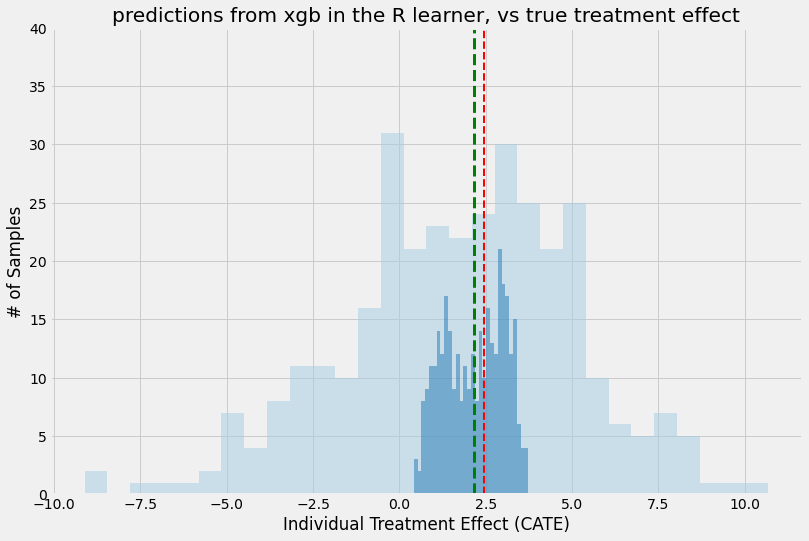

In [10]:
### 
alpha=0.5
bins=30
plt.figure(figsize=(12,8))
plt.hist(stacking_data[i], alpha=alpha, bins=bins, label='R Learner - XGB')
plt.hist(treatment[i][1][assignment[i][1] == 1], alpha=alpha, bins=bins, label='true treatment effect')
plt.axvline(treatment[i][1][assignment[i][1] == 1].mean(), color='g', linestyle='dashed', linewidth=3)
plt.axvline(ate_r_XGBRegressor[1], color='r', linestyle='dashed', linewidth=2)

##(WHAT ABOUT THE TRUE ATE?)

plt.ylim(0, 40)
plt.title('predictions from xgb in the R learner, vs true treatment effect')
plt.xlabel('Individual Treatment Effect (CATE)')
plt.ylabel('# of Samples')
#_=plt.legend().subtract(in_num1, in_num2)

In [11]:
A = treatment[i][1][assignment[i][1] == 1]
B = stacking_data[i]

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(A, B)

print(mse) 

### WHY IS MSE SO BAD HERE? 

9.76772233224428


In [29]:
##### THE STACKING PART!!
## stacking data has three columns, of all the predictions on 332 values. 
## what is y output? for the stacking part it will be the true treatment effect: 

from sklearn import linear_model
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

y_stacking = treatment[i][1][assignment[i][1] == 1]
reg = LinearRegression().fit(np.transpose(stacking_data), y_stacking)

print(reg.coef_)
print(reg.intercept_)

### not a great sign for the coefs here is it?

[0.0884421  0.02583179 0.00993586]
1.9194431968735401
